# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Determinación-de-los-parámetros-de-los-polarizadores-lineales" data-toc-modified-id="Determinación-de-los-parámetros-de-los-polarizadores-lineales-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Determinación de los parámetros de los polarizadores lineales</a></div><div class="lev2 toc-item"><a href="#Tarjeta-de-adquisición-de-datos" data-toc-modified-id="Tarjeta-de-adquisición-de-datos-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tarjeta de adquisición de datos</a></div><div class="lev2 toc-item"><a href="#Parametros-iniciales" data-toc-modified-id="Parametros-iniciales-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Parametros iniciales</a></div><div class="lev2 toc-item"><a href="#Motores" data-toc-modified-id="Motores-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Motores</a></div><div class="lev2 toc-item"><a href="#Rotación-de-P4---referencia-motor" data-toc-modified-id="Rotación-de-P4---referencia-motor-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Rotación de P4 - referencia motor</a></div><div class="lev2 toc-item"><a href="#Rotación-de-P4---referencia-polarizador" data-toc-modified-id="Rotación-de-P4---referencia-polarizador-15"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Rotación de P4 - referencia polarizador</a></div><div class="lev2 toc-item"><a href="#Final" data-toc-modified-id="Final-16"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Final</a></div>

# Medir un elemento de polarizacion

**Autor**: Jesús del Hoyo

**Fecha**:   06/02/2019

**Objetivo**: Ecograb project, polariscope callibration

**Configuración**:

Se puede utilizar tanto en transmisión como en reflexión, empleando el fotodiodo como detector.

**Elementos ópticos**:
1. Diodo láser de Roithner .... de longitud de onda $\lambda$=850 nm.
1. Lente colimadora de Thorlabs DG10-600-B.
1. Polarizador 0 LPNIRE100-B.
1. Retardador  0 $\lambda/4$ Thorlabs WPQ10E-850-SP.
1. Polarizador 1 LPNIRE100-B (P1).
1. Retardador  1 $\lambda/4$ Thorlabs WPQ10E-850-SP (R1).
1. Elementos previos a la muestra. Deben estar caracterizados para que el análisis funcione.
1. MUESTRA. 
1. Elementos posteriores a la muestra. Deben estar caracterizados para que el análisis funcione.
1. Retardador  2 $\lambda/4$ Thorlabs WPQ10E-850-SP (R2).
1. Polarizador 2 LPNIRE100-B (P2).
1. Fotodiodo (ver cual).



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function, division

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import datetime
import pprint
from math import pi

from scipy.io import savemat, loadmat

from polarimeter.utils import dibujar_2d_fitting, sort_positions, plot_2d_scattered, generate_even_distribution
from polarimeter.polarimeter import get_calibration, degrees, polarimeter_experiment, Intensity_Rotating_Elements

from phyton_optics.polarization_mueller_analysis import filter_reality_conditions, all_parameters, decompose_polar
import phyton_optics.polarization_stokes as ps


## Preparar los experimentos

### Tarjeta de adquisición de datos.

In [3]:
from polarimeter.daca import u3, LabJackPython, get_intensity, V, mV

In [4]:
# loads labjack
d=u3.U3()
data_callibration=d.getCalibrationData()
AIN_signal=1
AIN_ref=2

# print("\n Callibration data:")
# pprint.pprint(data_callibration)

## Check that daca is working
# 
ain1bits, = d.getFeedback(u3.AIN(AIN_signal)) # Read from raw bits from AIN0
ainValue = d.binaryToCalibratedAnalogVoltage(ain1bits, isLowVoltage = False, channelNumber = 0)
print(ainValue)
ain1bits, = d.getFeedback(u3.AIN(AIN_ref)) # Read from raw bits from AIN0
ainValue = d.binaryToCalibratedAnalogVoltage(ain1bits, isLowVoltage = False, channelNumber = 0)
print(ainValue)

1.9661076006
4.73943835613


### Motores

In [5]:
from polarimeter.motors.rotary_motors import Motors
Comports = [3, 4, 5, 7] 
Vels=[50,50,50,50]

In [6]:
motors = Motors(RS232_COMPORT=Comports, init_vels=Vels) 

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0

Connected to (c)2013 Physik Instrumente(PI) Karlsruhe, C-663.11,0,1.2.1.0



### Parametros iniciales

In [7]:
%pwd

u'C:\\Users\\luismiguel\\software\\polarimeter\\polarimeter\\motors'

In [8]:
# Load calibration file
path_absolute = 'C:\Users\luismiguel\software\polarimeter'
pol_dict=get_calibration(path_absolute + '\\polarimeter')
# Extract initial angles
theta1 = pol_dict["th0p1"]/degrees # Change with future calibrations
theta2 = pol_dict['th0r1']/degrees
theta3 = pol_dict['th0r2']/degrees
theta4 = pol_dict['th0p2']/degrees # Change with future calibrations
theta0 = np.array([theta1, theta2, theta3, theta4])
print("theta_1={}º, theta_2={}º, theta_3={}º, theta_4={}º".format(theta1, theta2, theta3, theta4))
# Extract simulation parameters
# Mr2 = ps.Mueller_Real_Retarder(pol_dict["R2p1"], pol_dict["R2p2"], pol_dict["Dr2"])
Mpol = [pol_dict["Mp1"], pol_dict["Mr1"], pol_dict["Mr2"], pol_dict["Mp2"]]  # Fix in future calibrations
# Mpol = [pol_dict["Mp1"], pol_dict["Mr1"], Mr2, pol_dict["Mp2"]]
Ifuente = pol_dict["Ifuente"]
print(Ifuente)
# Calculate date for filenames
fecha = datetime.date.today()

theta_1=172.035259954º, theta_2=162.685923673º, theta_3=55.7988087191º, theta_4=35.7033406896º
[[ 4.28253414]
 [ 0.30042142]
 [ 0.30169475]
 [ 4.26131739]]


### Sistema de archivos

Es muy deseable crear una carpeta que contenga todos los archivos de una misma calibracion. Tenemos tres tipos de archivos diferentes: este mismo notebook, que guarda las instrucciones dadas a los motores. Están también los archivos npz en que se guardan los datos experimentales y que son importables por python. Y por último, está el script usado para realizar los calculos para determinar la matriz de Mueller, del que también merece la pena guardar una copia por si se modifica en el futuro.

En este paso, creamos la carpeta y colocamos ahí el directorio activo, de tal manera que se guarden ahí todos los datos.

In [9]:
# Paths and names
path_medidas = path_absolute + '\\notebooks\Medir_Mueller'
new_folder = 'Medidas_{}'.format(fecha)
path_medidas_new = path_medidas + '\\' + new_folder
path_process = path_absolute + '\\polarimeter'
name_notebook = 'Medir_Mueller_Fotodiodo_1.0.ipynb'
name_process = 'data_process.py'
# Save bookmarks
%bookmark absolute $path_absolute
%bookmark medidas $path_medidas
%bookmark med_folder $path_medidas_new
%bookmark process $path_process
%bookmark -l -
# Create calibration folder
%cd medidas
%mkdir $new_folder
%cd med_folder

Current bookmarks:
absolute   -> C:\Users\luismiguel\software\polarimeter
med_folder -> C:\Users\luismiguel\software\polarimeter\notebooks\Medir_Mueller\Medidas_2019-02-11
medidas    -> C:\Users\luismiguel\software\polarimeter\notebooks\Medir_Mueller
process    -> C:\Users\luismiguel\software\polarimeter\polarimeter
(bookmark:medidas) -> C:\Users\luismiguel\software\polarimeter\notebooks\Medir_Mueller
C:\Users\luismiguel\software\polarimeter\notebooks\Medir_Mueller
(bookmark:med_folder) -> C:\Users\luismiguel\software\polarimeter\notebooks\Medir_Mueller\Medidas_2019-02-11
C:\Users\luismiguel\software\polarimeter\notebooks\Medir_Mueller\Medidas_2019-02-11


Ya existe el subdirectorio o el archivo Medidas_2019-02-11.


### Otros

In [48]:
def medir_intensidades():
    I = np.array(
        [get_intensity(d=d, u=u3, AIN_number=AIN_signal, verbose=True), get_intensity(d=d, u=u3, AIN_number=AIN_ref, verbose=True)]
    )
    return I

def generar_dict_de_param():
    dict = {}
    dict["theta0"] = theta0
    dict["Nmedidas"] = N
    dict["type_angles"] = type_angles
    dict["limits"] = limits
    dict["Nlimit"] = Nlimit
    dict["Imodel"] = Imodel
    dict["todos"] = todos    
    return dict
    

**Iluminación**

Poner la fuente al mismo voltaje y corriente que durante la calibración.

T = 25 deg C.

I = 270 mA.

## Experimento de medida de matriz de polarización

Aquí vamos a tomar una serie de medidas para calcular la matriz de Mueller de una muestra.

In [12]:
# Background level
motors.move(
        positions = [theta1, 
                     theta2, 
                     theta3, 
                     theta4], 
        velocities=Vels, kind='absolute',  verbose=False)
intensity_0 = medir_intensidades()

-0.0243, 0.0115, 

motor     = (-164.23, 150.09,  16.43, 125.33)
absolute  = (-164.23, -150.09, -16.43, 125.33)
polarizer = (-167.02, -194.67, -148.19, -36.55)
0.1752, 4.7087, 0.3082, 4.7087, 0.3543, 4.7036, 0.3697, 4.7087, 0.1701, 4.6934, 0.2161, 4.6985, 0.0575, 4.7036, 0.0729, 4.7087, 0.3082, 4.7036, 0.2520, 4.7139, 0.3594, 4.6985, 0.3390, 4.6985, 0.3697, 4.7087, 0.0729, 4.7087, 0.0371, 4.7139, 0.3697, 4.7190, 0.1343, 4.6985, 0.0422, 4.6985, 0.2366, 4.7036, -0.0039, 4.7292, 0.2622, 4.7292, 0.1547, 4.6678, 0.2724, 4.7292, 0.1496, 4.7190, 0.1906, 4.7343, 0.0473, 4.7343, -0.0141, 4.7036, -0.0090, 4.7087, -0.0090, 4.7087, 0.2110, 4.7241, 0.2366, 4.7241, 0.0729, 4.7190, -0.0141, 4.7036, 0.1189, 4.7241, 0.2110, 4.7599, 0.2161, 4.7599, 0.3441, 4.7292, 0.2571, 4.7650, 0.0678, 4.7599, 0.3031, 4.7701, 0.2161, 4.7292, -0.0141, 4.7446, 0.1394, 4.7343, 0.2213, 4.7650, 0.0166, 4.7497, 0.0985, 4.7394, 0.1138, 4.7394, 0.0217, 4.7292, 0.3441, 4.7343, 0.2264, 4.7446, 0.0933, 4.7446, -0.0192, 4.7394, 0.0166, 4.7343, 0.00

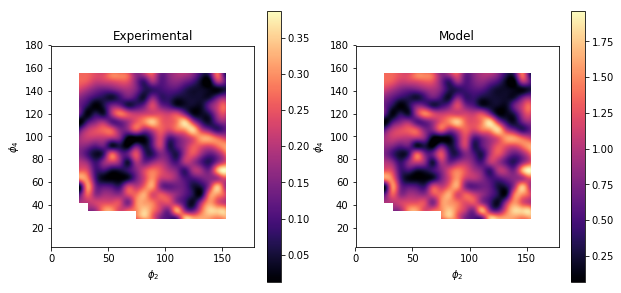

In [64]:
# Parámetros
N = 200 # Numero de medidas
todos = False # Mover todos los motores (True) o solo los de los rotadores (False).
#filename="Polarizador_LPNIRE100B_60deg_lrandom_{}".format(datetime.date.today())
filename="Difusor_DG10-600B_0deg_random_{}".format(datetime.date.today())
#filename="Retardador_WQ10E-850-SP_30deg_random_{}".format(datetime.date.today())
#filename="Papel_linear_ret_{}".format(datetime.date.today())
#filename="Aire_def_{}".format(datetime.date.today())
#filename="Polarizador_malo_90deg_linear_ret_{}".format(datetime.date.today())
type_angles = 'random'
limits = [180, 180, 180, 180]
Nlimit = [0, 0, 0, 0]

# Preparar los ángulos aleatorios
if type_angles == 'Random' or 'random':
    angles = np.random.rand(N,4)*limits
else:
    angles = generate_even_distribution(Nmeasures=N, limits=limits, method=type_angles, N_total_motors=4)
#print(angles)
# Ordenarlos
pos_ini = motors.get_position()
angles = sort_positions(angles, pos_ini[1])

# Empezar a medir
I = np.zeros([N,2])
Imodel = np.zeros(N)
for ind in range(N):
    angles_ind = np.array([angles[ind,0], angles[ind,1], angles[ind,2], angles[ind,3]])
    motors.move(
        positions = angles_ind - theta0, 
        velocities=Vels, kind='absolute',  verbose=False)
    I[ind,:] = medir_intensidades()
    Imodel[ind] = Intensity_Rotating_Elements(Mpol, angles_ind*degrees, Ei=Ifuente)
I = I - intensity_0
param = generar_dict_de_param()

# Save data
np.savez(filename+'.npz', angulos = angles, parametros = param, intensidad=I)
print("\nExperimento concluido con exito")

# Plot result
I_to_fit = I[:,0] * I[:,1] / pol_dict["normal"]
cond1 = (limits[0] == 0 and limits[3] == 0) or (Nlimit[0] <= 1 and Nlimit[3] <= 1)
if cond1:    
    plt.figure(figsize=(10, 5))       
    plt.subplot(1,2,1)
    plot_2d_scattered(angles[:,1], angles[:,2], I_to_fit, xy_are_angles=False)    
    plt.title('Experimental')   
    plt.subplot(1,2,2)   
    plot_2d_scattered(angles[:,1], angles[:,2], Imodel, xy_are_angles=False)  
    plt.title('Model')   

## Analisis

En esta parte analizamos la medida realizada y calculamos la matriz de Mueller.

In [63]:
tolerance = 1e-3
is_vacuum = False
m00 = 0.96948
# Recompose data
angles_to_fit = np.array(angles).T*degrees
# Calculate Mueller Matrix
Mcalculated = polarimeter_experiment(Mpol, Ifuente, I_to_fit, angles_to_fit)
if is_vacuum:
    m00 = Mcalculated[0,0]
    print("m00: {}".format(m00))
    Mtarget = np.eye(4)
Mnormalized = Mcalculated / m00
if is_vacuum:
    error = np.linalg.norm(Mtarget-Mnormalized)/16
    print("RMS error: {}".format(error))
# Filter it
Mfiltered = filter_reality_conditions(Mnormalized, tol=tolerance, verbose=True)
# Analyze filtered matrix
all_parameters(Mnormalized, tol=tolerance)
decompose_polar(Mnormalized, decomposition='DRP', verbose=True, co=False, tol=tolerance, filter=False)

The original matrix is:
[[ 0.92521621 -0.01041838  0.00143058 -0.00030389]
 [-0.0080405   0.91780236 -0.02188195  0.07154757]
 [-0.00402858 -0.02435219  0.80377491  0.45550182]
 [-0.00116411 -0.06134921 -0.46213596  0.78521353]]
Sixth condition was violated. Fixed matrix is:
[[ 0.81235781 -0.12390589  0.01463176 -0.        ]
 [-0.1211335   0.80245257 -0.00309093  0.        ]
 [ 0.01559565 -0.00691996  0.79914448 -0.        ]
 [ 0.          0.          0.          0.78968148]]
The original matrix is:
[[ 0.81235781 -0.12390589  0.01463176 -0.        ]
 [-0.1211335   0.80245257 -0.00309093  0.        ]
 [ 0.01559565 -0.00691996  0.79914448 -0.        ]
 [ 0.          0.          0.          0.78968148]]
None condition was violated.
 
Parameters of the matrix:
  The matrix is not physically consistent:
    - Sixth condition violated (distance = -0.00405404631956)
  The matrix is depolarizing:
    - The degree of polarimetric purity is: 0.993769633756
    - The ddepolarization degree is: 0.

(matrix([[ 1.        ,  0.        ,  0.        ,  0.        ],
         [ 0.00254215,  0.9952806 , -0.00431049,  0.00586327],
         [-0.00583289, -0.00431049,  0.99892869, -0.00721936],
         [-0.00095392,  0.00586327, -0.00721936,  0.98700819]]),
 matrix([[ 1.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.99705405, -0.01706518,  0.07477969],
         [ 0.        , -0.02263513,  0.86605387,  0.49943803],
         [ 0.        , -0.07328625, -0.49965935,  0.86311625]]),
 matrix([[ 0.92521621, -0.01041838,  0.00143058, -0.00030389],
         [-0.01041838,  0.92521505, -0.00000805,  0.00000171],
         [ 0.00143058, -0.00000805,  0.9251575 , -0.00000023],
         [-0.00030389,  0.00000171, -0.00000023,  0.92515644]]))

## Final

Ahora vamos a copiar el script utilizado para realizar el ajuste, y este notebook. IMPORTANTE: Comprueba los nombres de archivo y localizaciones, no pueden guardarse en variables y hay que cambiarlo manualmente ahora. 

In [34]:
# Recordar fecha para nombre de archivos
fecha = datetime.date.today()
print(fecha)

2019-02-07


In [37]:
# Go to script folder
%cd process
# Copy the file
%copy $name_process $path_medidas_new
# Go to notebook folder
%cd medidas
# Copy the file
%copy $name_notebook $path_medidas_new

(bookmark:process) -> C:\Users\luismiguel\software\polarimeter\polarimeter
C:\Users\luismiguel\software\polarimeter\polarimeter
        1 archivo(s) copiado(s).
(bookmark:medidas) -> C:\Users\luismiguel\software\polarimeter\notebooks\Medir_Mueller
C:\Users\luismiguel\software\polarimeter\notebooks\Medir_Mueller
        1 archivo(s) copiado(s).


Finalmente, cerrar los motores.

In [38]:
# Cerrar motores
motors.close()
del motors
LabJackPython.Close()

## Experimento de ayuda

Este experimento es una prueba para comprobar que los angulos iniciales estan bien calculados.

In [42]:
from polarimeter.daca import get_two_intensities
from polarimeter.utils import plot_2d
# Two dimensions
num_dataX = 9
num_dataY = 8
angles2x = sp.linspace(0,180,num_dataX)
angles2y = sp.linspace(0,180,num_dataY)
intensities_2 = np.zeros([num_dataX, num_dataY, 2],dtype=float)
Imodel2 = np.zeros([num_dataX, num_dataY],dtype=float)



2.0122, 4.7855, 1.8791, 4.7957, 1.5209, 4.8008, 1.2702, 4.7957, 1.3470, 4.8008, 1.6949, 4.8008, 1.9917, 4.8008, 1.9508, 4.8060, 1.5823, 4.8060, 1.1781, 4.8060, 1.0553, 4.8008, 1.3265, 4.8008, 1.7666, 4.8008, 2.0070, 4.8060, 

1.8689, 4.8008, 1.6898, 4.8008, 1.2446, 4.8008, 0.8404, 4.8008, 0.7995, 4.7957, 1.1628, 4.8008, 1.6796, 4.8008, 1.9968, 4.7957, 1.9456, 4.7906, 1.6591, 4.7957, 1.4442, 4.7906, 1.4954, 4.8060, 1.7307, 4.8008, 1.8689, 4.7957, 

1.5056, 4.7906, 1.2549, 4.8008, 0.8251, 4.7855, 0.4208, 4.7906, 0.3185, 4.7906, 0.6357, 4.7906, 1.2190, 4.7906, 1.7666, 4.7906, 2.0122, 4.7906, 1.9508, 4.7906, 1.7512, 4.7906, 1.6079, 4.7804, 1.5619, 4.7957, 1.4954, 4.7957, 

1.1781, 4.7753, 0.7995, 4.7906, 0.4055, 4.7804, 0.1240, 4.7906, 0.0780, 4.7906, 0.3697, 4.7906, 0.8865, 4.7804, 1.4544, 4.7804, 1.8587, 4.7753, 2.0122, 4.7804, 1.9456, 4.7753, 1.7512, 4.7855, 1.4851, 4.7804, 1.1730, 4.7804, 

1.1525, 4.8060, 0.6255, 4.7855, 0.2059, 4.7855, 0.0319, 4.7804, 0.1496, 4.7804, 0.4822, 4.8008

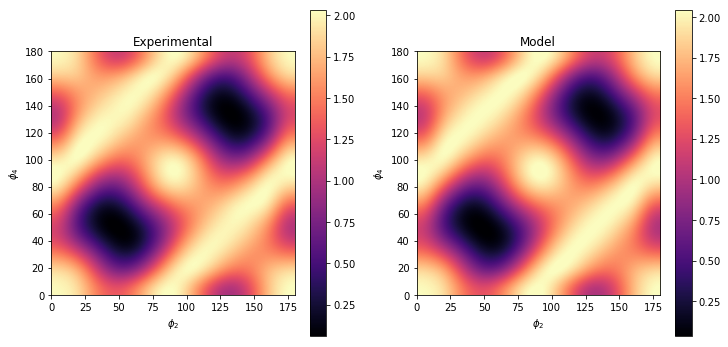

In [47]:
# Hacer el experimento
for ind1, angleDim1 in enumerate(angles2x):
    print("\n")
    for ind2, angleDim2 in enumerate(angles2y):
        pos = np.array([0, angleDim1, angleDim2, 0])
        delay = [0, 0, 0, 90]
        motors.move(
            positions = pos - theta0, velocities=Vels, kind='absolute',  verbose=False)
        intensities_2[ind1, ind2, :] = get_two_intensities(AIN_signal, AIN_ref, u=u3, d=d, verbose=True)
        Imodel2[ind1, ind2] = Intensity_Rotating_Elements(Mpol, pos*degrees, Ei=Ifuente)
intensity2 = intensities_2 - intensity_0
intensity2 = intensity2[:,:,0] * intensity2[:,:,1] / pol_dict["normal"]
# Plot results, 2D
plt.figure(figsize=(12, 6))   
plt.subplot(1,2,1)
plot_2d(angles2x, angles2y, intensity2, title='Experimental', xy_are_angles=False)
plt.subplot(1,2,2)
print(Imodel2.shape)
plot_2d(angles2x, angles2y, Imodel2, title='Model', xy_are_angles=False)